- LSTM
  - RNN을 발전시킨 형태
  - 장기기억을 담당하는 셀 상태와 은닉상태를 갖는 신경망
- BOW
  - 모든 단어를 겹치지 않도록 고유 번호로 나타낸 집합
- 희소표현
  - 대부분의  숫자가 0으로 구성된 숫자표현
- 파이토치의 임베디드층
  - 희소표현을 밀집표현으로 변경할 수 있다  

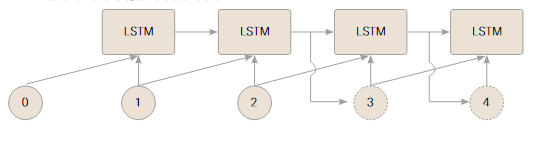

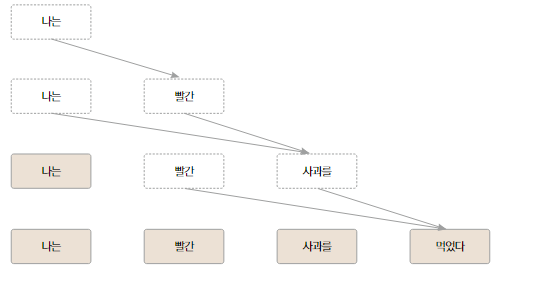

In [1]:
# 뉴욕타임즈 코멘트 데이터 사용 - from kaggle
# 바로가기 : https://drive.google.com/file/d/1yWWIwv8-4mE4qCCTj3i8xtzovupM_31s/view?usp=sharing

In [2]:
import pandas as pd

In [3]:
!unzip '/content/drive/MyDrive/NYT-COMMENT-TEXT/archive.zip'

Archive:  /content/drive/MyDrive/NYT-COMMENT-TEXT/archive.zip
  inflating: ArticlesApril2017.csv   
  inflating: ArticlesApril2018.csv   
  inflating: ArticlesFeb2017.csv     
  inflating: ArticlesFeb2018.csv     
  inflating: ArticlesJan2017.csv     
  inflating: ArticlesJan2018.csv     
  inflating: ArticlesMarch2017.csv   
  inflating: ArticlesMarch2018.csv   
  inflating: ArticlesMay2017.csv     
  inflating: CommentsApril2017.csv   
  inflating: CommentsApril2018.csv   
  inflating: CommentsFeb2017.csv     
  inflating: CommentsFeb2018.csv     
  inflating: CommentsJan2017.csv     
  inflating: CommentsJan2018.csv     
  inflating: CommentsMarch2017.csv   
  inflating: CommentsMarch2018.csv   
  inflating: CommentsMay2017.csv     


In [4]:
df = pd.read_csv('/content/ArticlesApril2017.csv')
df.head(2)

,abstract,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,NaN,58def1347c459f24986d7c80,716,By STEPHEN HILTNER and SUSAN LEHMAN,article,Finding an Expansive View of a Forgotten Peop...,"['Photography', 'New York Times', 'Niger', 'Fe...",3,Insider,2,2017-04-01 00:15:41,Unknown,One of the largest photo displays in Times his...,The New York Times,News,https://www.nytimes.com/2017/03/31/insider/nig...
1,NaN,58def3237c459f24986d7c84,823,By GAIL COLLINS,article,"And Now, the Dreaded Trump Curse","['United States Politics and Government', 'Tru...",3,OpEd,23,2017-04-01 00:23:58,Unknown,Meet the gang from under the bus.,The New York Times,Op-Ed,https://www.nytimes.com/2017/03/31/opinion/and...


In [5]:
# 학습용 데이터 만들기
# 1.전처리(구두점하고 특수문자 제거)
# 2.단어마다 고유번호를 만들어준다
# 3. 문장속 단어들을 전부 고유번호로 바꿔준다
# BOW(Bag of Word)

In [6]:
from collections import Counter

In [7]:
c = Counter('gallahad')
c

Counter({'g': 1, 'a': 3, 'l': 2, 'h': 1, 'd': 1})

In [8]:
import numpy as np
import glob
from torch.utils.data.dataset import Dataset

In [9]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
class TextGeneration(Dataset):
  def clean_text(self, txt):
    # 문장에서 punctuation를제거하고 전부 소문자로 변경
    return "".join([character for character in txt if character not in string.punctuation])

  # BOW 를이용해서 시계열 데이터를 생성
  def generate_sequence(self,txt):
    seq = []
    for line in txt:
      line = line.split()
      line_BOW =  [self.BOW[word] for word in line]
      # 단어를2개를 입력으로 받고 다음 단어를 정답
      data = [ ([line_BOW[i],line_BOW[i+1]], line_BOW[i+2])   for i in range(len(line_BOW)-2) ]
      seq.extend(data)
    return seq


  def __init__(self,file_path='./*Articles*.csv'):
    all_headlines=[]
    # 헤드라인의 텍스트를 가져옴
    for filename in glob.glob(file_path):  # 000/0000/*Articles*.csv
      article_df = pd.read_csv(filename)
      all_headlines.extend( list(article_df['headline'].values) )

    # Unknown 값 제거
    all_headlines = [h for h in  all_headlines if h != 'Unknown']

    # punctuation 제거
    self.corpus =  [self.clean_text(h) for h in all_headlines]
    self.BOW = {}

    # 모든 문장의 단어를 추출해서 고유번호 지정
    for line in self.corpus:
      for word in line.split():
        self.BOW[word] = len(self.BOW.keys())
    # 모델에 입력으로 사용될 데이터
    self.data = self.generate_sequence(self.corpus)

  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    data = np.array(self.data[index][0])
    label = np.array(self.data[index][1]).astype(np.float32)
    return data, label

LSTM 모델 정의
  - 만약에 전체 단어의 개수가 5000개 이고 고유번호가 100이면..  100번째만 1이고 나머지는 0인
  - 이렇게 데이터를 만들어서 입력으로 사용하면 대부분이 0이므로 학습이 잘 안됨 그래서 밀집형태로 변경

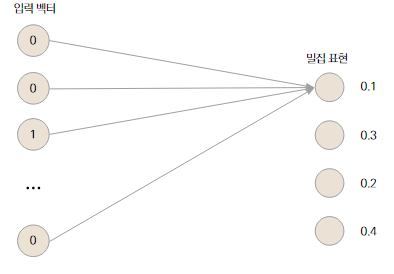

In [11]:
# 입력 -> 임베디드층 -> LSTM ->rehsape -> MLP - >출력

In [12]:
import torch.nn as nn
import torch

In [13]:
# LSTM모델 (LSTM층을 5개정도 쌓는다)
class LSTM(nn.Module):
  def __init__(self, num_embeddings):
    super(LSTM,self).__init__()
    # embedding_dim=16 단어나 토큰의 개수
    self.embed = nn.Embedding(num_embeddings=num_embeddings,embedding_dim=16)

    self.lstm = nn.LSTM(
       input_size = 16, hidden_size=64,num_layers=5,batch_first=True
    )
    # 분류
    self.fc1 = nn.Linear(128, num_embeddings)  # 실제 학습시 error 정보를 이용해서 in_feature 값 계산
    self.fc2 = nn.Linear(num_embeddings, num_embeddings)
    self.relu = nn.ReLU()
  def forward(self,x):
    x = self.embed(x)
    x, _ = self.lstm(x)  # RNN과 비슷하게 전체 출력값과 마지막 은닉상태를반환
    x = torch.reshape(x, (x.shape[0],-1))
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

In [14]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [15]:
import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = TextGeneration()
model = LSTM(num_embeddings=len(dataset.BOW)).to(device)
loader = DataLoader(dataset,batch_size=32)
optim = Adam(model.parameters())

In [17]:
# 학습루프
for epoch in range(10):  # 200번 수행
  iter = tqdm.tqdm(loader)
  for data,label in iter:
    optim.zero_grad()
    pred = model(torch.tensor(data,dtype=torch.long).to(device).clone().detach())
    loss = nn.CrossEntropyLoss()(pred,torch.tensor(label,dtype=torch.long).to(device))
    #역전파
    loss.backward()
    optim.step()
    iter.set_description(f"epoch:{epoch} loss:{loss.item()}")
torch.save(model.state_dict(),'lstm.pth')


  0%|          | 0/131 [00:00<?, ?it/s]<ipython-input-17-afb43ff11c25>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(data,dtype=torch.long).to(device).clone().detach())
<ipython-input-17-afb43ff11c25>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = nn.CrossEntropyLoss()(pred,torch.tensor(label,dtype=torch.long).to(device))
epoch:9 loss:3.1133689880371094: 100%|██████████| 131/131 [00:34<00:00,  3.78it/s]


In [ ]:
list(dataset.BOW.keys())

In [58]:
# 평가 : 문장 만들기 문장의 길이 10
def generate(model, BOW, input_str = 'finding an', strlen = 10):
  with torch.no_grad():
    for p in range(strlen):
      # 입력문장을 텐서로 변경
      words = torch.tensor(
          [BOW[w] for w in input_str.split()],dtype=torch.long
          ).to(device)

      # 모델의 입력이되기 위해서는 배치 차원 추가
      input_tensor = torch.unsqueeze(words[-2:],dim=0)  # 예측하기 위해서 마지막 두 문장을 사용
      output = model(input_tensor)
      output_word =  torch.argmax(output).cpu().numpy()
      #문장에 예측된 단어를 추가
      input_str += " " + list(BOW.keys())[output_word] + " "

  print(f"predicted sentence : {input_str}")

In [ ]:
# pd.read_csv( glob.glob("./*Articles*.csv")[0]).head()
dataset.BOW.keys()

In [62]:
model.load_state_dict(torch.load('lstm.pth',map_location=device))
generate(model,dataset.BOW,input_str='The Opioid')

0
1
2
3
4
5
6
7
8
9
predicted sentence : The Opioid GIs  GIs  GIs  GIs  GIs  GIs  GIs  GIs  GIs  GIs 
